In [1]:
import os
import sys

import pandas as pd
import numpy as np

from datetime import datetime,timedelta

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import sklearn.metrics as sklm
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'

# set font size
# plt.rcParams['font.size'] = 24
# plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120, 'font.size':10})

In [2]:
def expo_model(x,p,N0=3,X0=1):
    return N0*(1+p)**(x-X0)

# def logistic_model(x,a,b,c):
#     return c/(1+np.exp(-(x-b)/a))

def logistic_model(x,a,b,c):
    return c/(1 + a * np.exp(-b * x))

def gompertz_model(x,a,b,c):
    return c*np.exp(-b*np.exp(-x/a)) 

### Illustrate Exponential growth example

In [3]:
# def f_exponential(t,r,x0):
#     return x0*(1+r)**t

In [4]:
# r = [2,1,0.5]

# temp = []

# for t in range(0, 31):
#     r1 = f_exponential(t, r[0], 0.01)
#     r2 = f_exponential(t, r[1], 0.01)
#     r3 = f_exponential(t, r[2], 0.01)
#     temp.append((t, r1, r2, r3))

# exp_df = pd.DataFrame(temp, columns=['day','r=2','r=1','r=0'])
# del temp
# # print(exp_df)
# # exp_df.style.hide_index()

# format_dict = {'r=2':'${0:,.2f}', 'r=1': '${0:,.2f}', 'r=0': '${0:,.2f}'}
# exp_df.style.format(format_dict).hide_index()


In [5]:
# temp = []

# for t in range(0, 25):
#     res = f_exponential(t, 1, 2)
#     temp.append((t, res))

# exp_df = pd.DataFrame(temp, columns=['hour','N'])
# del temp
# # print(exp_df)
# # exp_df.style.hide_index()

# format_dict = {'N':'{0:,.0f}'}
# exp_df.style.format(format_dict).hide_index()


### Illustrate Exponential, Logistic, Gompertz

(-1000.0, 150000.0)

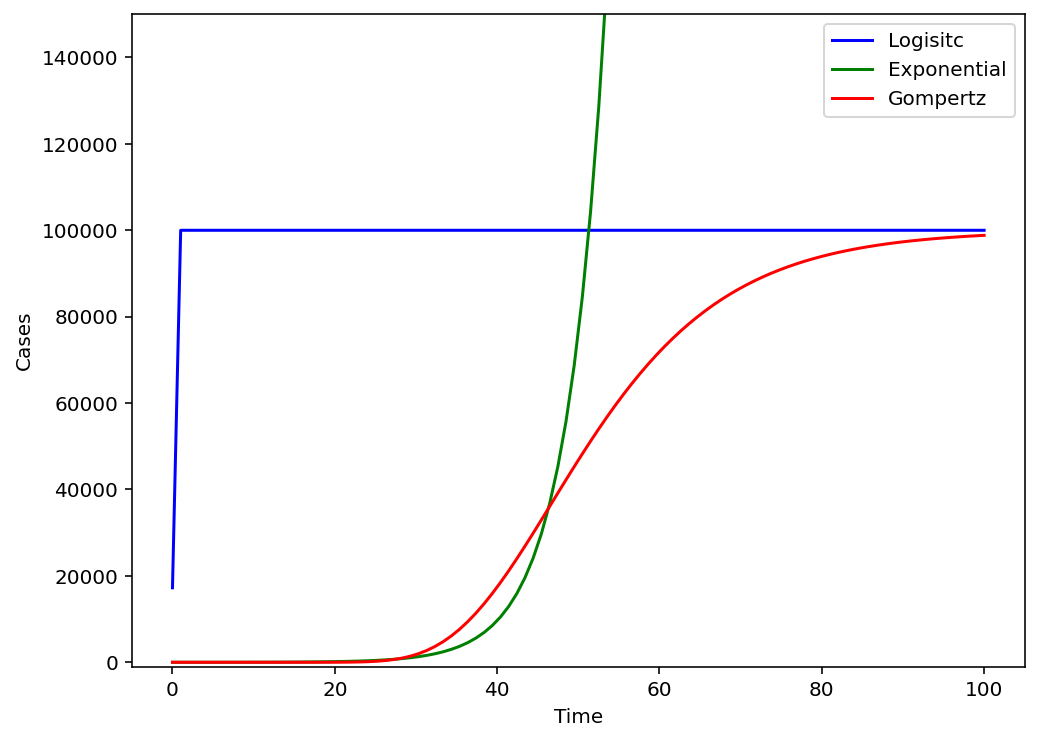

In [6]:
fig = plt.figure(figsize= (8,6))
tt= np.linspace(0,100,100)
plt.plot(tt, logistic_model(tt,4.8,50,100000), c='b', label='Logisitc')
plt.plot(tt, expo_model(tt, 0.23), c='g', label='Exponential')
plt.plot(tt, gompertz_model(tt, 12, 49, 100000), c='r', label='Gompertz')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cases')
plt.ylim(-1000,150000)

### COVID-19 Data

In [7]:
data_dir = '/Users/genie/data/covid-19/'

In [8]:
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/genie/data/covid-19/.DS_Store
/Users/genie/data/covid-19/jhu_time_series_covid19_deaths_global_narrow.csv
/Users/genie/data/covid-19/owid-covid-data.csv
/Users/genie/data/covid-19/eiu_democracy_indices.csv
/Users/genie/data/covid-19/jhu_time_series_covid19_confirmed_global_narrow.csv
/Users/genie/data/covid-19/jhu_time_series_covid19_recovered_global_narrow.csv
/Users/genie/data/covid-19/us_daily.csv


In [9]:
%%time

data = pd.read_csv(os.path.join(data_dir,'owid-covid-data.csv'))
data = data[data.iso_code.notnull()][['iso_code', 'location', 
       'date', 'total_cases', 'new_cases','total_deaths', 'new_deaths', 'total_tests','new_tests', 'population']]
data = data.rename(columns={'location':'country_name'})

# Merge recoveries data from JHU dataset
recovered_df = pd.read_csv(os.path.join(data_dir,'jhu_time_series_covid19_recovered_global_narrow.csv'))
recovered_df = recovered_df.rename(columns={'iso_country_code':'iso_code','recovered':'total_recoveries'})
recovered_df = recovered_df.groupby(['iso_code','date'])['total_recoveries'].sum().reset_index()
recovered_df['date'] = pd.to_datetime(recovered_df['date'])
recovered_df['date'] = recovered_df['date'].dt.strftime('%Y-%m-%d')
recovered_df['new_recoveries'] = recovered_df['total_recoveries'] - recovered_df.sort_values(by=['date'], ascending=True)\
.groupby(['iso_code'])['total_recoveries'].shift(1)
data = pd.merge(data, recovered_df, how='left', on=['iso_code','date'])
del recovered_df

CPU times: user 393 ms, sys: 43.5 ms, total: 437 ms
Wall time: 465 ms


### EXAMPLE

In [54]:
# iso_code = 'IND'
# cases_starting_point = 100

# df = data[(data.iso_code == iso_code) & (data.total_cases >= cases_starting_point)][['date','total_cases','new_cases']]
# df['time'] = df.reset_index().index

# # cutoff_date = '2020-05-31'
# # df = df[df.date <= cutoff_date]

# ##remove last data point to make prediction
# x = np.array(list(df.time.values))[0:-1]  
# y = np.array(list(df.total_cases.values))[0:-1]

# y0 = y[0]
# yf = y[-1]

# country_name = data[data.iso_code == iso_code].country_name.values[0]

# print("~~ Prediction for {}-{} as of {} ~~".format(country_name, iso_code, df.date.max()))
# print("Initial no. of cases on {} -> {}".format(df.date.min(), y0))
# print("No. of cases on {} -> {}".format(df.date.values[-2], yf))
# print('>>> Exponential Model')
# fit_exp = curve_fit((lambda tt,pp: expo_model(tt,pp,N0=y0)),x,y,p0=[0.10])  ##Take N0 from initial number of reported cases
# pi, sigma_pi = fit_exp[0][0], np.sqrt(fit_exp[1]).flatten()[0]

# print([ss+'='+'{:.3f}'.format(xx) for ss, xx in zip(('p','sigma_p'),(pi,sigma_pi))])

# y_pred = expo_model(x,pi)
# MSLE=sklm.mean_squared_log_error(y,y_pred)
# print("Mean squared log error (MSLE): ", '{:.3f}'.format(MSLE))
# print("Exp of RMSLE: ", '{:.3f}'.format(np.exp(np.sqrt(MSLE))))
# print("R2 score: ", '{:.3f}'.format(sklm.r2_score(y,y_pred)))

# ## Logistic
# # print('\n')
# print('>>> Logistic Model')

# # fit_i = curve_fit(logistic_model,x,y,p0=[3,50,5000], maxfev=10000)#, bounds=([0,0,0],[10,100,150000]))

# fit_i = curve_fit(logistic_model,x,y,p0=np.random.exponential(size=3))#, bounds=([0,0,0],[10,100,150000]))

# # fit_i = curve_fit(logistic_model,x,y,p0=[3,50,5000], bounds=([0,0,0],[10,100,150000]))

# # fit_i = curve_fit(logistic_model,x,y, p0=np.random.exponential(size=3) , bounds=([0,0,0],[10,10,10000000000]))
# ai,bi,ci = fit_i[0]
# sigma_ai, sigma_bi, sigma_ci = np.sqrt(np.diag(fit_i[1]))

# print([ss+'='+'{:.3f}'.format(xx) for ss, xx in zip(('a','b','c'),(ai,bi,ci))])
# print([ss+'='+'{:.3f}'.format(xx) for ss, xx in zip(('sigma_a','sigma_b','sigma_c'),(sigma_ai,sigma_bi,sigma_ci))])

# y_pred = logistic_model(x,ai,bi,ci)
# MSLE=sklm.mean_squared_log_error(y,y_pred)
# print("Mean squared log error (MSLE): ", '{:.3f}'.format(MSLE))
# print("Exp of RMSLE: ", '{:.3f}'.format(np.exp(np.sqrt(MSLE))))
# print("R2 score: ", '{:.3f}'.format(sklm.r2_score(y,y_pred)))

# perc_flat = 0.98
# sol = int(fsolve(lambda x : logistic_model(x,ai,bi,ci) - perc_flat*int(ci), bi))
# datesol = datetime.strftime(datetime.strptime(df.date.min(),'%Y-%m-%d') + timedelta(days=sol), ' %d, %b %Y' )
# print('Day of flattening of the infection curve -> {}'.format(datesol))

In [66]:
iso_codes = ['CHN','THA','KOR','JPN','AUS','NZL','CAN','IRN','TUR','RUS','GBR','FRA','ITA','BRA','IND','USA']

for iso_code in iso_codes:
    cases_starting_point = 100
    
    df = data[(data.iso_code == iso_code) & (data.total_cases >= cases_starting_point)][['date','total_cases','new_cases']]
    df['time'] = df.reset_index().index

    # cutoff_date = '2020-05-31'
    # df = df[df.date <= cutoff_date]

    x = np.array(list(df.time.values))[0:-1]  
    y = np.array(list(df.total_cases.values))[0:-1]

    y0 = y[0]
    yf = y[-1]

    country_name = data[data.iso_code == iso_code].country_name.values[0]

    print("**** Prediction for {}-{} as of {} ****".format(country_name, iso_code, df.date.max()))
    print("Initial no. of cases on {} -> {}".format(df.date.min(), y0))
    print("No. of cases on {} -> {}".format(df.date.values[-2], yf))

    # Exponential Model
    fit_exp = curve_fit((lambda tt,pp: expo_model(tt,pp,N0=y0)),x,y,p0=[0.10])  ##Take N0 from initial number of reported cases
    pi, sigma_pi = fit_exp[0][0], np.sqrt(fit_exp[1]).flatten()[0]
    exp_y_pred = expo_model(x,pi)
    exp_MSLE=sklm.mean_squared_log_error(y,exp_y_pred)
    exp_RMLSE = np.exp(np.sqrt(MSLE))
    exp_r2_score = sklm.r2_score(y,exp_y_pred)
    print("~~ Exponential Model ~~")
    print([ss+'='+'{:.3f}'.format(xx) for ss, xx in zip(('p','sigma_p'),(pi,sigma_pi))])
    print("MSLE: {:.3f}, Exp of RMSLE: {:.3f}, R2 score: {:.3f}".format(exp_MSLE, exp_RMLSE, exp_r2_score))

    # Logistic Model
    fit_i = curve_fit(logistic_model,x,y,p0=np.random.exponential(size=3), bounds=([0,0,0],[10,10,1000000000000]))
    ai,bi,ci = fit_i[0]
    sigma_ai, sigma_bi, sigma_ci = np.sqrt(np.diag(fit_i[1]))
    log_y_pred = logistic_model(x,ai,bi,ci)
    log_MSLE=sklm.mean_squared_log_error(y,log_y_pred)
    log_RMLSE = np.exp(np.sqrt(log_MSLE))
    log_r2_score = sklm.r2_score(y,log_y_pred)
    print("~~ Logistic Model ~~")
    print([ss+'='+'{:.3f}'.format(xx) for ss, xx in zip(('a','b','c'),(ai,bi,ci))], [ss+'='+'{:.3f}'.format(xx) for ss, xx in zip(('sigma_a','sigma_b','sigma_c'),(sigma_ai,sigma_bi,sigma_ci))])
    print("MSLE: {:.3f}, Exp of RMSLE: {:.3f}, R2 score: {:.3f}".format(log_MSLE, log_RMLSE, log_r2_score))
    
    perc_flat = 0.98
    sol = int(fsolve(lambda x : logistic_model(x,ai,bi,ci) - perc_flat*int(ci), bi))
    datesol = datetime.strftime(datetime.strptime(df.date.min(),'%Y-%m-%d') + timedelta(days=sol), ' %d, %b %Y' )
    print('Day of flattening of the infection curve -> {}'.format(datesol))
    print('\n')

**** Prediction for China-CHN as of 2020-07-29 ****
Initial no. of cases on 2020-01-19 -> 216.0
No. of cases on 2020-07-28 -> 86783.0
~~ Exponential Model ~~
['p=0.035', 'sigma_p=0.001']
MSLE: 45.617, Exp of RMSLE: 9.670, R2 score: -9.730
~~ Logistic Model ~~
['a=10.000', 'b=0.113', 'c=84166.683'] ['sigma_a=1.115', 'sigma_b=0.005', 'sigma_c=390.112']
MSLE: 0.418, Exp of RMSLE: 1.909, R2 score: 0.963
Day of flattening of the infection curve ->  13, Mar 2020


**** Prediction for Thailand-THA as of 2020-07-29 ****
Initial no. of cases on 2020-03-16 -> 114.0
No. of cases on 2020-07-28 -> 3297.0
~~ Exponential Model ~~
['p=0.029', 'sigma_p=0.001']
MSLE: 22.803, Exp of RMSLE: 9.670, R2 score: -11.185
~~ Logistic Model ~~
['a=9.005', 'b=0.139', 'c=3111.112'] ['sigma_a=0.666', 'sigma_b=0.004', 'sigma_c=10.831']
MSLE: 0.030, Exp of RMSLE: 1.190, R2 score: 0.984
Day of flattening of the infection curve ->  28, Apr 2020


**** Prediction for South Korea-KOR as of 2020-07-29 ****
Initial no. of c